## What was the best Halloween costume you spotted in 2025? 🎃

### 1. Prolific Setup and Authentication
- Import required libraries
- Load API key from environment variables
- Authenticate and fetch your Prolific researcher ID

In [32]:
import importlib
import prolific_helpers
importlib.reload(prolific_helpers)


<module 'prolific_helpers' from '/Users/vivianamarquez/Documents/github_repos/demo-prolific-meetup-2/prolific_helpers.py'>

In [33]:
import os
import json
import yaml
import requests

import pandas as pd
import matplotlib.pyplot as plt

from prolific_helpers import (
    get_researcher_id,
    create_survey,
    create_study,
    publish_study,
    show_study_results,
    plot_survey_responses,
    plot_responses_by_generation,
    plot_responses_by_gender
)

In [21]:
# Load configuration
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

In [3]:
# Read API tokens for Jupyter Notebook
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
prolific_token = os.environ.get('PROLIFIC_API_TOKEN')
prolific_workspace = os.environ.get('PROLIFIC_WORKSPACE_ID')
prolific_project = os.environ.get('PROLIFIC_PROJECT_ID')

In [5]:
# Set up headers for authenticated requests to the Prolific API
headers = {
    "Authorization": f"Token {prolific_token}",
    "Content-Type": "application/json",
}

In [6]:
# Fetch your Prolific researcher ID
researcher_id = get_researcher_id(headers)

### 2. Survey Creation

In [7]:
# Build survey question from config
question_text = config['survey']['question_text']
print(question_text)

What costume do you think was the most unique this year?


In [8]:
# Create survey using helper function
survey_id = create_survey(headers, researcher_id, config['survey'])
print(f"Survey created with ID: {survey_id}")

Survey created with ID: 690bcac40002552637753b64


### 3. Study Publication
- Create the study with all parameters
- Publish it to make it available to participants
- Monitor study status and participant recruitment

In [9]:
# Prepare study configuration from config.yaml
study_config = {
    "name": config['study']['name'],
    "description": config['study']['description'],
    "privacy_notice": config['study']['privacy_notice'],
    "reward": config['participants']['reward'],
    "participants": config['participants']['total_participants'],
    "estimated_time": config['participants']['estimated_time'],
    "max_time": config['participants']['max_time'],
    "device_compatibility": config['device_compatibility']
}

# Create study using helper function
study_id = create_study(headers, survey_id, study_config, prolific_project)
print(f"Study created with ID: {study_id}")

Study created with ID: 690bcac49e212c5277c46be1


In [10]:
# Publish study using helper function
status_code = publish_study(headers, study_id)
print(f"Study published with status code: {status_code}")

Study published with status code: 200


# RESULTS
- Monitor participant submissions
- Export results in CSV format
- Load data into pandas DataFrame for analysis
- Calculate completion times and response statistics

In [36]:
# Fetch and display study results using helper function and configured timezone
df = show_study_results(study_id, headers, config['timezone'])

✅ Study Name: One mutiple choice question about Halloween this year
📊 Status: ACTIVE
👥 Total Places: 20
📩 Total Submissions: 19
⏳ Created at: 05 Nov 2025, 02:08 PM PST
🕒 Last Response At: 05 Nov 2025, 02:14 PM PST
⏱️ Time Lapsed: 6 minutes


In [37]:
df.head()

,Submission id,Participant id,Status,Custom study tncs accepted at,Started at,Completed at,Reviewed at,Archived at,Time taken,Completion code,...,Student status,Employment status,Long-term health condition/disability,Fluent languages,Sexual orientation,Highest education level completed,Degree subject,Work role,Submission approval rate,What costume do you think was the most unique this year?
0,690bcae6335f177b3b69a9d8,6668c9df1d76dc85e0f95d40,APPROVED,Not Applicable,2025-11-05T22:08:41.451000Z,2025-11-05T22:09:18.290000Z,2025-11-05T22:14:10.473000Z,2025-11-05T22:11:28.945000Z,37.0,NOCODE,...,No,Full-Time,No,English,heterosexual,Undergraduate degree (BA/BSc/other),Information and Communication Technologies,Individual contributor / Non-manager,100,Louvre security guard costume
1,690bcae6fd2ed10228f0bba8,5e3d57c40d3a26000edff2e1,APPROVED,Not Applicable,2025-11-05T22:08:40.190000Z,2025-11-05T22:08:56.141000Z,2025-11-05T22:14:08.054000Z,2025-11-05T22:11:28.947000Z,16.0,NOCODE,...,No,Part-Time,No,English,heterosexual,Undergraduate degree (BA/BSc/other),Natural sciences,None of the above,99,Louvre security guard costume
2,690bcae716c7ce3f6030d108,665a9ddb536966183500a7b1,APPROVED,Not Applicable,2025-11-05T22:08:40.544000Z,2025-11-05T22:08:55.057000Z,2025-11-05T22:14:09.299000Z,2025-11-05T22:11:28.948000Z,15.0,NOCODE,...,Yes,Full-Time,No,"Turkish, English",heterosexual,Graduate degree (MA/MSc/MPhil/other),"Engineering, manufacturing and construction",Manager,99,Labubu
3,690bcaeac58162cfba9049ce,606b197a43dfda2edcd80803,APPROVED,Not Applicable,2025-11-05T22:08:43.943000Z,2025-11-05T22:08:57.254000Z,2025-11-05T22:14:11.963000Z,2025-11-05T22:11:28.950000Z,14.0,NOCODE,...,No,Full-Time,No,Chinese,heterosexual,Undergraduate degree (BA/BSc/other),DATA_EXPIRED,DATA_EXPIRED,100,Louvre security guard costume
4,690bcaecf97290f44e065076,5d12ce9596919a0019367dd4,APPROVED,Not Applicable,2025-11-05T22:08:45.594000Z,2025-11-05T22:09:06.122000Z,2025-11-05T22:14:13.368000Z,2025-11-05T22:11:28.951000Z,21.0,NOCODE,...,No,Full-Time,No,English,heterosexual,Undergraduate degree (BA/BSc/other),"Engineering, manufacturing and construction",Manager,100,Labubu


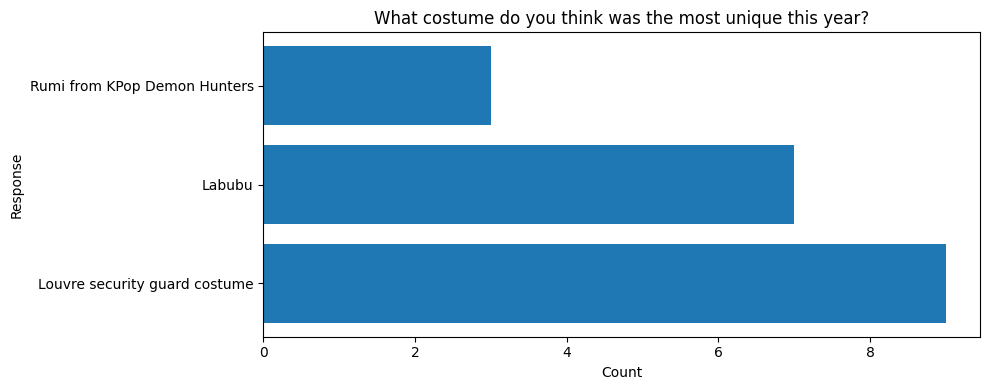

In [38]:
# Plot survey responses using helper function
question_column = config['survey']['question_text']
fig, ax = plot_survey_responses(df, question_column)
plt.show()

### Results by Generation
Breakdown of responses by age generation with labeled age ranges

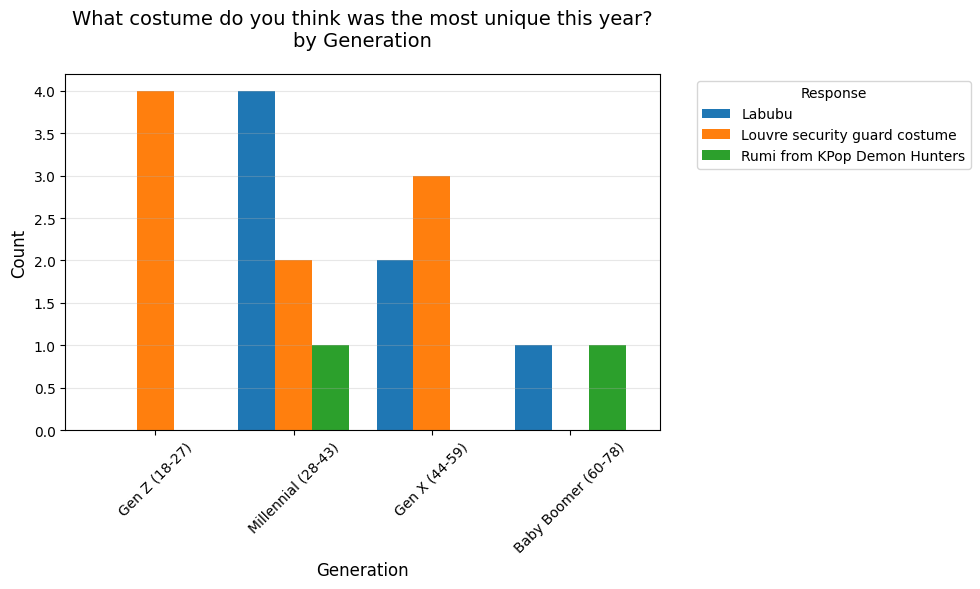

In [35]:
# Plot responses by generation
fig, ax = plot_responses_by_generation(df, question_column)
plt.show()

### Results by Gender
Breakdown of responses by gender/sex

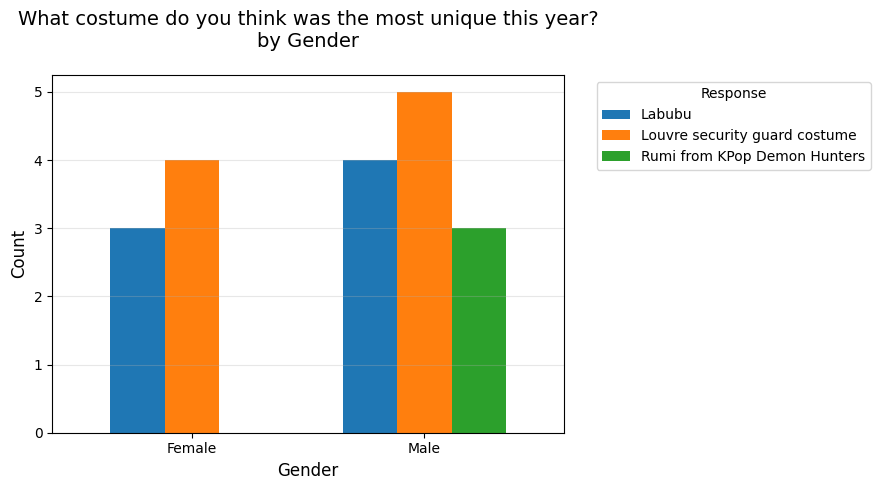

In [39]:
# Plot responses by gender
fig, ax = plot_responses_by_gender(df, question_column)
plt.show()